In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import string
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from keras.initializers import Constant
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Embedding
import tensorflow as tf
import time
import os
import copy

In [3]:
path='/content/drive/MyDrive/consumer finance'
dir_list = os.listdir(path)
print(dir_list)

['consumer_complaints_clean_1.csv', 'Untitled0.ipynb']


In [4]:
data = pd.read_csv('/content/drive/MyDrive/consumer finance/consumer_complaints_clean_1.csv')
data.head()

,Unnamed: 0,consumer_complaint_narrative,product
0,190126,XXXX claimed owe XXXX years despite PROOF PAYM...,Debt collection
1,190135,Due inconsistencies amount owed told Bank amou...,Consumer Loan
2,190155,XXXX wages earned job decreased almost half XX...,Mortgage
3,190207,open current mortgage Chase Bank XXXX Chase re...,Mortgage
4,190208,XXXX submitted XXXX time submitted complaint d...,Mortgage


In [5]:
data.shape

(66806, 3)

In [6]:
data.columns

Index(['Unnamed: 0', 'consumer_complaint_narrative', 'product'], dtype='object')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    66806 non-null  int64 
 1   consumer_complaint_narrative  66806 non-null  object
 2   product                       66806 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [8]:
miss_col_train = data.isnull().sum()[data.isnull().sum() > 0].sort_values(ascending=True)
percent_miss_train = round((miss_col_train / len(data) * 100) , 2)
missing_train = pd.DataFrame([miss_col_train, percent_miss_train]).T.rename(columns={0:'Feature', 1:'missing'})
missing_train

,Feature,missing


In [9]:
pd.set_option('max_colwidth', 500)
data[['consumer_complaint_narrative']].head(5)

,consumer_complaint_narrative
0,XXXX claimed owe XXXX years despite PROOF PAYMENT sent canceled check ownPAID INVOICE They continue insist owe collection agencies How stop harassment bill already paid four years ago
1,Due inconsistencies amount owed told Bank amount reported credit reporting agencies advised write good letter order address issue request negative entry removed credit report together vehicle stolen declared total loss insurance company The insurance company GAP insurancw companypaid outstanding balance loan told Bank still balance due loan good faith without received proof still balance made partial payment towards remaining debt sent goodwill letter still offering pay remainder debt exchan...
2,XXXX wages earned job decreased almost half XXXX knew trouble home loan began contacting WFB home loan assitance options early XXXX began Loan Modification process Wells Fargo Bank told would not assist anything financial home loan fell days behind though time started inquire assistance WFB weeks behind began working program called XXXX They approved variety assistence reached Wells Fargo Bank determine could assist Wells Fargo turned assistance XXXX finally offered Loan Modification The out...
3,open current mortgage Chase Bank XXXX Chase reporting loan payments XXXX XXXX surpressing information reporting loan Discharged This mortgage reaffirmed Chapter XXXX discharged dated XXXX XXXX Chase keeps referring Law Chapter XXXX keep providing documentation Chapter XXXX account open current payments
4,XXXX submitted XXXX time submitted complaint dealt Rushmore Mortgage directly endeavoring get stop continuous daily calls receiving trying collect mortgage not responsible due bankruptcy They denied knowledge bankruptcy even though spoken repeatedly written repeatedly referencing bankruptcy requesting cease pursuit continued When unable trick paying force paying retaliation placed reported credit bureaus past due mortgage amount discharged Federal Court XXXX Rushmore responded referenced com...


In [10]:
data['consumer_complaint_narrative'].str.lower()

0                                                                                                                                                                                                                                                                                                                                    xxxx claimed owe xxxx years despite proof payment sent canceled check ownpaid invoice they continue insist owe collection agencies how stop harassment bill already paid four years ago
1        due inconsistencies amount owed told bank amount reported credit reporting agencies advised write good letter order address issue request negative entry removed credit report together vehicle stolen declared total loss insurance company the insurance company gap insurancw companypaid outstanding balance loan told bank still balance due loan good faith without received proof still balance made partial payment towards remaining debt sent goodwill letter still offering pay remaind

In [11]:
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punctuations_numbers(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)

def tokenization(inputs):
    return word_tokenize(inputs)

In [14]:
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(remove_number)
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(remove_url)
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(remove_html)
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(remove_punctuations_numbers)
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(tokenization)

In [15]:
data.iloc[100]['consumer_complaint_narrative']

['contacted',
 'Drivetime',
 'several',
 'different',
 'occasions',
 'regarding',
 'car',
 'loan',
 'account',
 'XXXX',
 'not',
 'number',
 'loan',
 'removed',
 'also',
 'credit',
 'bureau',
 'positive',
 'credit',
 'rating',
 'closed',
 'paid',
 'full',
 'The',
 'company',
 'insisted',
 'avoiding',
 'agreement',
 'entered',
 'XXXX',
 'company',
 'representative',
 'corporate',
 'position',
 'agreed',
 'upon',
 'resolution',
 'provide',
 'agency',
 'copy',
 'not',
 'capability',
 'computer',
 'Drivetime',
 'month',
 'XXXX',
 'XXXX',
 'removed',
 'credit',
 'reporting',
 'information',
 'XXXX',
 'credit',
 'bureaus',
 'reporting',
 'agencies',
 'believe',
 'XXXX',
 'XXXX',
 'XXXX',
 'discovered',
 'XXXX',
 'XXXX',
 'positive',
 'credit',
 'ratings',
 'longer',
 'XXXX',
 'XXXX',
 'credit',
 'bureaus',
 'another',
 'positive',
 'account',
 'another',
 'car',
 'loan',
 'longer',
 'reporting',
 'credit',
 'file',
 'removals',
 'adversely',
 'affecxted',
 'credit',
 'ratings',
 'ability',
 '

In [16]:
data['consumer_complaint_narrative'].head()

0                                                                                                                                                                                                                                                                                                   [XXXX, claimed, owe, XXXX, years, despite, PROOF, PAYMENT, sent, canceled, check, ownPAID, INVOICE, They, continue, insist, owe, collection, agencies, How, stop, harassment, bill, already, paid, four, years, ago]
1    [Due, inconsistencies, amount, owed, told, Bank, amount, reported, credit, reporting, agencies, advised, write, good, letter, order, address, issue, request, negative, entry, removed, credit, report, together, vehicle, stolen, declared, total, loss, insurance, company, The, insurance, company, GAP, insurancw, companypaid, outstanding, balance, loan, told, Bank, still, balance, due, loan, good, faith, without, received, proof, still, balance, made, partial, payment, towards, remaining, 

In [17]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stop_words.remove('not')

def stopwords_remove(inputs):
    return [k for k in inputs if k not in stop_words]

data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(stopwords_remove)
data['consumer_complaint_narrative'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


0                                                                                                                                                                                                                                                                                                   [XXXX, claimed, owe, XXXX, years, despite, PROOF, PAYMENT, sent, canceled, check, ownPAID, INVOICE, They, continue, insist, owe, collection, agencies, How, stop, harassment, bill, already, paid, four, years, ago]
1    [Due, inconsistencies, amount, owed, told, Bank, amount, reported, credit, reporting, agencies, advised, write, good, letter, order, address, issue, request, negative, entry, removed, credit, report, together, vehicle, stolen, declared, total, loss, insurance, company, The, insurance, company, GAP, insurancw, companypaid, outstanding, balance, loan, told, Bank, still, balance, due, loan, good, faith, without, received, proof, still, balance, made, partial, payment, towards, remaining, 

In [18]:
def word_length_filter(inputs):
    return [j for j in inputs if len(j) > 2]

data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(word_length_filter)
data['consumer_complaint_narrative'].head()

0                                                                                                                                                                                                                                                                                                   [XXXX, claimed, owe, XXXX, years, despite, PROOF, PAYMENT, sent, canceled, check, ownPAID, INVOICE, They, continue, insist, owe, collection, agencies, How, stop, harassment, bill, already, paid, four, years, ago]
1    [Due, inconsistencies, amount, owed, told, Bank, amount, reported, credit, reporting, agencies, advised, write, good, letter, order, address, issue, request, negative, entry, removed, credit, report, together, vehicle, stolen, declared, total, loss, insurance, company, The, insurance, company, GAP, insurancw, companypaid, outstanding, balance, loan, told, Bank, still, balance, due, loan, good, faith, without, received, proof, still, balance, made, partial, payment, towards, remaining, 

In [19]:
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].str.join(' ')
data['consumer_complaint_narrative'].head()

0                                                                                                                                                                                                                                                                                                                                XXXX claimed owe XXXX years despite PROOF PAYMENT sent canceled check ownPAID INVOICE They continue insist owe collection agencies How stop harassment bill already paid four years ago
1    Due inconsistencies amount owed told Bank amount reported credit reporting agencies advised write good letter order address issue request negative entry removed credit report together vehicle stolen declared total loss insurance company The insurance company GAP insurancw companypaid outstanding balance loan told Bank still balance due loan good faith without received proof still balance made partial payment towards remaining debt sent goodwill letter still offering pay remainder debt 

In [20]:
text = data['consumer_complaint_narrative'].tolist()
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(text)

sequences = tokenizer_obj.texts_to_sequences(text)
word_index = tokenizer_obj.word_index

In [21]:
max_sequence_length = max(len(encoded_text) for encoded_text in sequences)
pad = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post', padding='post')
max_sequence_length

582

In [22]:
X = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post', padding='post')
print(X[0])

[    1   641   130     1    43   504   162     8    27  1197    54 25414
  1500    15   239  2241   130    44   249   509   207   858    82   200
    28  1175    43   199     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [23]:
X = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post', padding='post')
print(X[0])

[    1   641   130     1    43   504   162     8    27  1197    54 25414
  1500    15   239  2241   130    44   249   509   207   858    82   200
    28  1175    43   199     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [24]:
print('Found %s unique tokens.' % len(word_index))
print(X.shape)
print(X)

Found 51051 unique tokens.
(66806, 582)
[[   1  641  130 ...    0    0    0]
 [  38 4959   40 ...    0    0    0]
 [   1 1223 1819 ...    0    0    0]
 ...
 [ 148   51  514 ...    0    0    0]
 [ 327  760  503 ...    0    0    0]
 [   9  138 4331 ...    0    0    0]]


In [25]:
num_words = len(word_index) + 1
print(num_words)

51052


In [26]:
product_list = list(data['product'].unique())
print(product_list)
print(len(product_list))

['Debt collection', 'Consumer Loan', 'Mortgage', 'Credit card', 'Credit reporting', 'Student loan', 'Bank account or service', 'Payday loan', 'Money transfers', 'Other financial service', 'Prepaid card']
11


In [27]:
labels = []
for i in data['product']:
    labels.append(product_list.index(i))
print(len(set(labels)))

11


In [28]:
y = np.array(labels)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1125, random_state=41)

tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')

# Convert X_train and X_test to lists of strings
X_train = [str(x) for x in X_train.tolist()]
X_test = [str(x) for x in X_test.tolist()]

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(X_train)

# Convert the training and test sets to tokenized sequences
Tokenized_train = tokenizer.texts_to_sequences(X_train)
Tokenized_val = tokenizer.texts_to_sequences(X_test)

In [30]:
maxlen = max_sequence_length
padded_train = pad_sequences(Tokenized_train, maxlen=maxlen, padding='pre')
padded_val = pad_sequences(Tokenized_val, maxlen=maxlen, padding='pre')

In [31]:
maxlen

582

In [32]:
'''import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.optimizers import Adam


# Updated hyperparameters for a larger model
embed_dim = 300  # Increased embedding dimension for better representation
lstm_out = 128  # Increased number of LSTM units
dropout_rate = 0.5  # Dropout rate to prevent overfitting
num_words = 20000  # Example vocabulary size
dense_units = 128  # Increased number of neurons in the Dense layer

model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=num_words, output_dim=embed_dim))  # input_length removed
model.add(Dropout(dropout_rate))  # Regularization

# First Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(lstm_out,
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l2(0.01),
                             recurrent_regularizer=tf.keras.regularizers.l2(0.01))))
model.add(Dropout(dropout_rate))

# Second Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(lstm_out,
                             kernel_regularizer=tf.keras.regularizers.l2(0.01),
                             recurrent_regularizer=tf.keras.regularizers.l2(0.01))))
model.add(Dropout(dropout_rate))

# Additional Dense Layer to increase model complexity
model.add(Dense(dense_units, activation='relu'))
model.add(Dropout(dropout_rate))

# Output Layer for Binary Classification
model.add(Dense(11, activation='sigmoid'))

# Compile the model with a lower learning rate for fine-tuning
optimizer = Adam(learning_rate=3e-4)  # Lower learning rate for larger model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Print the model summary
model.summary()'''

"import tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense\nfrom tensorflow.keras.optimizers import Adam\n\n\n# Updated hyperparameters for a larger model\nembed_dim = 300  # Increased embedding dimension for better representation\nlstm_out = 128  # Increased number of LSTM units\ndropout_rate = 0.5  # Dropout rate to prevent overfitting\nnum_words = 20000  # Example vocabulary size\ndense_units = 128  # Increased number of neurons in the Dense layer\n\nmodel = Sequential()\n\n# Embedding Layer\nmodel.add(Embedding(input_dim=num_words, output_dim=embed_dim))  # input_length removed\nmodel.add(Dropout(dropout_rate))  # Regularization\n\n# First Bidirectional LSTM Layer\nmodel.add(Bidirectional(LSTM(lstm_out,\n                             return_sequences=True,\n                             kernel_regularizer=tf.keras.regularizers.l2(0.01),\n                             recurrent_regularizer

In [33]:
print(padded_train.shape)
print(y_train.shape)
print(padded_val.shape)
print(y_test.shape)

(59290, 582)
(59290,)
(7516, 582)
(7516,)


In [34]:
y_train = tf.keras.utils.to_categorical(y_train, 11) # Use tf.keras.utils
y_test = tf.keras.utils.to_categorical(y_test, 11) # Use tf.keras.utils

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.optimizers import Adam

'''
# Hyperparameters
embed_dim = 128  # Embedding dimension
lstm_units = 100  # Number of LSTM units, reasonable size for sequence length 582
dropout_rate = 0.5  # Dropout to prevent overfitting
batch_size = 64  # Batch size for training
epochs = 10  # Number of epochs
learning_rate = 1e-4  # Learning rate

# Model architecture
model = Sequential()

# Embedding layer: input_dim is the vocabulary size (e.g., 20000), output_dim is the embedding size
model.add(Embedding(input_dim=20000, output_dim=embed_dim, input_length=582))

# First Bidirectional LSTM layer
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate)))

# Second Bidirectional LSTM layer
model.add(Bidirectional(LSTM(lstm_units, dropout=dropout_rate)))

# Dense layer with dropout for regularization
#model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))

# Output layer for binary classification
model.add(Dense(11, activation='softmax'))

# Compile the model with Adam optimizer and binary cross-entropy loss
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()
'''

"\n# Hyperparameters\nembed_dim = 128  # Embedding dimension\nlstm_units = 100  # Number of LSTM units, reasonable size for sequence length 582\ndropout_rate = 0.5  # Dropout to prevent overfitting\nbatch_size = 64  # Batch size for training\nepochs = 10  # Number of epochs\nlearning_rate = 1e-4  # Learning rate\n\n# Model architecture\nmodel = Sequential()\n\n# Embedding layer: input_dim is the vocabulary size (e.g., 20000), output_dim is the embedding size\nmodel.add(Embedding(input_dim=20000, output_dim=embed_dim, input_length=582))\n\n# First Bidirectional LSTM layer\nmodel.add(Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate)))\n\n# Second Bidirectional LSTM layer\nmodel.add(Bidirectional(LSTM(lstm_units, dropout=dropout_rate)))\n\n# Dense layer with dropout for regularization\n#model.add(Dense(64, activation='relu'))\nmodel.add(Dropout(dropout_rate))\n\n# Output layer for binary classification\nmodel.add(Dense(11, activation='softmax'))\n\n# Compile the 

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Hyperparameters
embed_dim = 128  # Embedding dimension
lstm_units = 100  # Number of LSTM units
dropout_rate = 0.5  # Dropout rate
batch_size = 32  # Batch size for training
epochs = 10  # Number of epochs
learning_rate = 1e-4  # Learning rate

# Model architecture
model = Sequential()

# Embedding layer: input_dim is the vocabulary size (e.g., 20000), output_dim is the embedding size
model.add(Embedding(input_dim=20000, output_dim=embed_dim, input_length=582))

# First Bidirectional LSTM layer
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate)))

# Second Bidirectional LSTM layer
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate)))

# Third Bidirectional LSTM layer (you can add more layers similarly)
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate)))

# Fourth Bidirectional LSTM layer (without return_sequences since this is the last LSTM)
model.add(Bidirectional(LSTM(lstm_units, dropout=dropout_rate)))

# Dense layer with dropout for regularization
# model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_rate))

# Output layer for multiclass classification (11 classes in this case)
model.add(Dense(11, activation='softmax'))

# Compile the model with Adam optimizer and categorical cross-entropy loss
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Assuming padded_train and y_train are defined, you can train the model as:
# history = model.fit(padded_train, y_train, validation_data=(padded_val, y_val), epochs=epochs, batch_size=batch_size)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 582, 128)          2560000   
                                                                 
 bidirectional (Bidirection  (None, 582, 200)          183200    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 582, 200)          240800    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 582, 200)          240800    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 200)               240800    
 onal)                                                  

In [37]:
'''model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(padded_train, y_train, batch_size=32, epochs=10)'''

"model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\n# Train the model\nmodel.fit(padded_train, y_train, batch_size=32, epochs=10)"

In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  mode='auto',
                                                  patience=5,
                                                  restore_best_weights=True)

epochs = 10
history = model.fit(padded_train, y_train, epochs=epochs,
                    validation_data=(padded_val, y_test),
                    callbacks=[early_stopping], batch_size=32)

Epoch 1/10
1853/1853 [==============================] - 392s 201ms/step - loss: 1.1762 - accuracy: 0.6083 - val_loss: 0.8347 - val_accuracy: 0.7366
Epoch 2/10
1853/1853 [==============================] - 330s 178ms/step - loss: 0.8091 - accuracy: 0.7543 - val_loss: 0.7492 - val_accuracy: 0.7696
Epoch 3/10
1853/1853 [==============================] - 327s 176ms/step - loss: 0.6898 - accuracy: 0.7880 - val_loss: 0.6518 - val_accuracy: 0.7946
Epoch 4/10
1853/1853 [==============================] - 318s 172ms/step - loss: 0.6085 - accuracy: 0.8201 - val_loss: 0.6070 - val_accuracy: 0.8163
Epoch 5/10
1853/1853 [==============================] - 325s 175ms/step - loss: 0.5465 - accuracy: 0.8401 - val_loss: 0.5799 - val_accuracy: 0.8249
Epoch 6/10
1853/1853 [==============================] - 325s 176ms/step - loss: 0.5031 - accuracy: 0.8539 - val_loss: 0.5661 - val_accuracy: 0.8313
Epoch 7/10
1853/1853 [==============================] - 324s 175ms/step - loss: 0.4651 - accuracy: 0.8647 - val_

In [39]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam

'''
# Load the tokenizer corresponding to your model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load a pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# ... (rest of your code)

# Ensure you use the correct tokenizer to process your data before training
# Example:
# inputs = tokenizer(your_text_data, return_tensors='tf', padding=True, truncation=True)
# padded_train = inputs['input_ids']

# Compile the model
#optimizer = Adam(learning_rate=2e-5)  # Lower learning rates are recommended for fine-tuning BERT
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()
history = model.fit(padded_train, y_train, epochs=3, validation_split=0.1, batch_size=32)
'''

"\n# Load the tokenizer corresponding to your model\ntokenizer = BertTokenizer.from_pretrained('bert-base-uncased')\n\n# Load a pre-trained BERT model for sequence classification\nmodel = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)\n\n# ... (rest of your code)\n\n# Ensure you use the correct tokenizer to process your data before training\n# Example:\n# inputs = tokenizer(your_text_data, return_tensors='tf', padding=True, truncation=True)\n# padded_train = inputs['input_ids']\n\n# Compile the model\n#optimizer = Adam(learning_rate=2e-5)  # Lower learning rates are recommended for fine-tuning BERT\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\n\n# Print the model summary\nmodel.summary()\nhistory = model.fit(padded_train, y_train, epochs=3, validation_split=0.1, batch_size=32)\n"

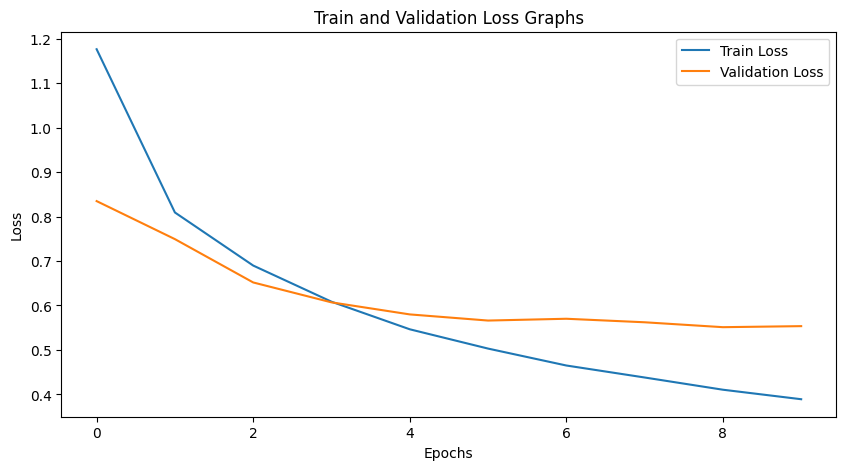

In [40]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss Graphs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

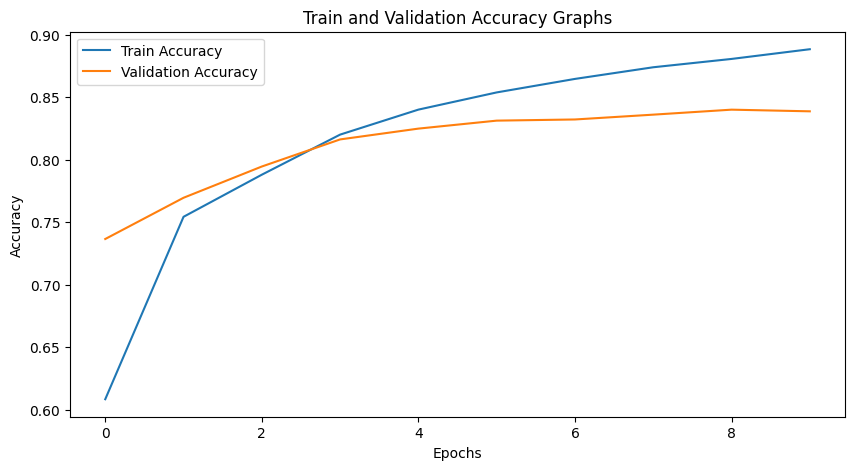

In [41]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy Graphs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 582, 128)          2560000   
                                                                 
 bidirectional (Bidirection  (None, 582, 200)          183200    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 582, 200)          240800    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 582, 200)          240800    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 200)               240800    
 onal)                                                  

In [43]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(tokenized_test, maxlen=maxlen, padding='pre')

test_evaluate = model.evaluate(padded_test, y_test)

235/235 [==============================] - 15s 63ms/step - loss: 0.5536 - accuracy: 0.8387


In [ ]:
pred_train_lstm = model.predict(padded_train)
pred_test_lstm = model.predict(padded_test)

In [45]:
padded_test.shape

(7516, 582)

(7516, 582)